<a href="https://colab.research.google.com/github/ritamghoshritam/Computer-Vision-Using-Python/blob/master/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
import cv2
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import shutil



print("check point 1: Data Preprocessing")
PATH = os.getcwd()
data_path = "//content//drive//My Drive//dataset"


img_rows=299
img_cols=299
num_channel= 3
num_epoch=25
 
num_classes = 2
labels_name = {'Unknown':0,'tennis':1}


img_data_list=[]
labels_list =[]
 
img_list=os.listdir(data_path)
print('Loading the images of dataset- ')

for img in img_list:
    input_img=cv2.imread(data_path+'/'+img)
    input_img_resize=cv2.resize(input_img,(299,299))
    img_data_list.append(input_img_resize)
    
print('Loading Dataset done')

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /=255
print (img_data.shape)

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples),dtype='int64')
labels[0:376]=0
labels[376:1605]=1


#print the count of the number of samples for different classes
print(np.unique(labels,return_counts=True))

#Convert Class labels to on-hot encoding
Y = np_utils.to_categorical(labels,num_classes)

#shuffle the dataset

x,y = shuffle(img_data,Y, random_state=2)

#split the dataset

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2)
'''
#for TPU
def train_input_fn(batch_size=128):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache() # Loads the data into memory since its such a small dataset
    dataset = dataset.shuffle(100, reshuffle_each_iteration=True)
    dataset = dataset.repeat() 
    dataset = dataset.batch(batch_size, drop_remainder=True)


    # Return the dataset.
    return dataset
 
def test_input_fn(batch_size=128):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    dataset = dataset.shuffle(100, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)


    # Return the dataset.
    return dataset


'''
########################
print("CheckPoint 2: Model Defining")

#model defining
#convolution Layer
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
  strides = int (strides) 
  x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
  x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
  if act:
    x = Activation('relu',name=name+'conv2d'+'act')(x)
  return x


def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay


def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

def incresC(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

 #stem cell
img_input = Input(shape=(299,299,3))

x = conv2d(img_input,32,3,2,'valid',True,name='conv1')
x = conv2d(x,32,3,1,'valid',True,name='conv2')
x = conv2d(x,64,3,1,'valid',True,name='conv3')

x_11 = MaxPooling2D(3,strides=2,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,96,3,2,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

#Inception-ResNet-A modules
x = incresA(x,0.15,name='incresA_1')
x = incresA(x,0.15,name='incresA_2')
x = incresA(x,0.15,name='incresA_3')
x = incresA(x,0.15,name='incresA_4')

#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

#Inception-ResNet-B modules
x = incresB(x,0.1,name='incresB_1')
x = incresB(x,0.1,name='incresB_2')
x = incresB(x,0.1,name='incresB_3')
x = incresB(x,0.1,name='incresB_4')
x = incresB(x,0.1,name='incresB_5')
x = incresB(x,0.1,name='incresB_6')
x = incresB(x,0.1,name='incresB_7')

#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

#Inception-ResNet-C modules
x = incresC(x,0.2,name='incresC_1')
x = incresC(x,0.2,name='incresC_2')
x = incresC(x,0.2,name='incresC_3')

#TOP
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(img_input,x,name='inception_resnet_v2')
model.compile(Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

#model.summary()



#for TPU
'''
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

'''


#############################################
#Augmentation
##############################################

'''
train_datagen = ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05,zoom_range=0.05,rescale=1/255.,
                                   fill_mode='nearest',channel_shift_range=0.2*255)


train_generator = train_datagen.flow_from_directory(X_train,target_size=(299, 299),batch_size=16,shuffle = True,class_mode='categorical')


validation_datagen = ImageDataGenerator(rescale=1/255.)

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,target_size=(299, 299),batch_size=batch_size,shuffle = True,
                                                           class_mode='categorical')
'''

###########################################

print ("Checkpoint 3: Training the Model")

#filepath = "//content//drive//My Drive//test//tennis.h5"


#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#early = EarlyStopping(monitor="val_loss",mode="min",patience=6, restore_best_weights=True)
#callbacks_list = [checkpoint, early]

#get_ipython().system_raw('./ngrok http 6006 &')
#! curl -s http://localhost:4040/api/tunnels | python3 -c \"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


#tpu_model.fit(X_train,y_train,steps_per_epoch = 60,epochs=100)


#hist = model.fit(X_train,y_train,batch_size=8,nb_epoch=num_epoch,verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)

hist = model.fit(X_train,y_train,batch_size=16,nb_epoch=num_epoch,verbose=1,validation_data=(X_test,y_test))


model.save_weights('//content//drive//My Drive//weights_tennis.h5')

#model = tpu_model.sync_to_cpu()

model.save('//content//drive//My Drive//test//tennis.h5')

#tpu_model.evaluate(x_test,y_test,batch=128)



In [0]:
# To Save model
import json
model_json = model.to_json()
with open("model_in_json.json", "w") as json_file:
    json.dump(model_json, json_file)

In [0]:
#To Visualize Graph
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

x = range(25)

plt.figure(1,figsize=(7,5))
plt.plot(x,train_loss)
plt.plot(x,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.style.use(['ggplot'])
plt.savefig('//content//drive//My Drive//train_loss_vs_val_loss.png')

plt.figure(2,figsize=(7,5))
plt.plot(x,train_acc)
plt.plot(x,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])
plt.savefig('//content//drive//My Drive//train_acc_vs_val_acc.png')

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install utils
!pip install utils util.visualization_utils

Unknown


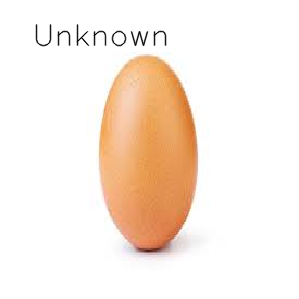

In [0]:
########################  Identifying Tennis Ball  ######################################
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json
from google.colab.patches import cv2_imshow

with open('//content//drive//My Drive//test//model_in_json.json','r') as f:
  model_json = json.load(f)

model = model_from_json(model_json)

model.load_weights('//content//drive//My Drive//tennis.h5','r')
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

x = 32
h = 45
img = cv2.imread('//content//drive//My Drive//test//egg.jpg')
#img = cv2.imread('//content//drive//My Drive//test//test.jpg')
img = Image.fromarray(img, 'RGB')
img = img.resize((299,299))
img_d = np.array(img)
img_array = np.expand_dims(img_d, axis=0)

c = int (model.predict(img_array)[0][1])

if(c==1):
  print("Tennis Ball")
  text = "Tennis Ball"
  cv2.putText(img_d, text, (x, h), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), lineType=cv2.LINE_AA)
  cv2_imshow(img_d)
else:
  print ("Unknown")
  text1 = "Unknown"
  cv2.putText(img_d, text1, (x, h), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), lineType=cv2.LINE_AA)
  cv2_imshow(img_d)



In [0]:
###############################               Predicting Tennis ball          ######################################################

import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import json
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam

with open('//content//drive//My Drive//test//model_in_json.json','r') as f:
  model_json = json.load(f)

model = model_from_json(model_json)

model.load_weights('//content//drive//My Drive//weights_tennis.h5','r')
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

x=32
h= 40

video = cv2.VideoCapture("//content//drive//My Drive//test//Tennis Ball Bounce.mp4")
print("loading Video complete")

out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (299,299))

while (video.isOpened()):
  ret,frame = video.read()
  #Convert the captured frame into RGB
  
  if ret == True:
    im = Image.fromarray(frame, 'RGB')
    #Resizing into 299x299 because we trained the model with this image size.
    im = im.resize((299,299))
    img_array = np.array(im)
  
    #Our keras model used a 4D tensor, (images x height x width x channel)
    #So changing dimension 128x128x3 into 1x299x299x3 
    
    img = np.expand_dims(img_array, axis=0)

    #Calling the predict method on model to predict 'tennis' in the image
  
    prediction = int(model.predict(img)[0][1])

    #if prediction is 1, which means I am detecting the image, then show the frame in gray color.
  
    if prediction == 1:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      text = "Tennis Ball"
      cv2.putText(img_array, text, (x, h), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
      out.write(img_array)
    else:
      text = "Unknown"
      cv2.putText(img_array, text, (x, h), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
      out.write(img_array)
    
    key=cv2.waitKey(1)
    if key == ord('q'):
      break
print("Complete Execution ")
out.release()    
video.release()
cv2.destroyAllWindows()